In [155]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

print("Libs loaded.")

Libs loaded.


1. Oblicz transformatę Fouriera dwóch poniższych obrazów typu B&W o wymiarach 512x512 pikseli. Oblicz i wyświetl widmo tych obrazów.

In [156]:
def create_image(type):
    width, height = 512, 512
    image = Image.new("RGB", (width, height), "black")
    image.save("images/black_image.png")
    print("images/black_image.png - SAVED")
    draw = ImageDraw.Draw(image)

    if type == "horizontal":
        print(type)
        rectangle_width, rectangle_height = 50, 10
        x1 = (width - rectangle_width) // 2
        y1 = height // 2 - rectangle_height // 2
        x2 = x1 + rectangle_width
        y2 = y1 + rectangle_height
        draw.rectangle([x1, y1, x2, y2], fill="white")
    elif type == "vertical":
        print(type)
        rectangle_width, rectangle_height = 10, 50
        x1 = width // 2 - rectangle_width // 2
        y1 = (height - rectangle_height) // 2
        x2 = x1 + rectangle_width
        y2 = y1 + rectangle_height
        draw.rectangle([x1, y1, x2, y2], fill="white")

    image.save(f"images/{type}_image.png")
    print(f"images/{type}_image.png - SAVED")


In [157]:
create_image("horizontal")

images/black_image.png - SAVED
horizontal
images/horizontal_image.png - SAVED


In [158]:
create_image("vertical")

images/black_image.png - SAVED
vertical
images/vertical_image.png - SAVED


In [159]:
image_horizontal_path = "images/horizontal_image.png"
image_vertical_path = "images/vertical_image.png"

In [160]:
def calculate_fourier_transform(image_path):
    image = np.array(Image.open(image_path).convert('L'))

    f_transform = np.fft.fft2(image)
    f_shift = np.fft.fftshift(f_transform)
    magnitude_spectrum = 20 * np.log(np.abs(f_shift))

    plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title(f'Fourier Transform - {image_path}')
    plt.show()

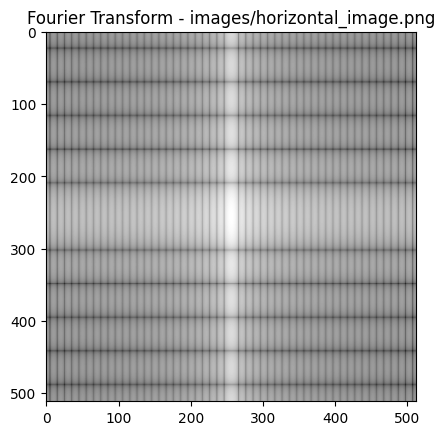

In [161]:
calculate_fourier_transform(image_horizontal_path)

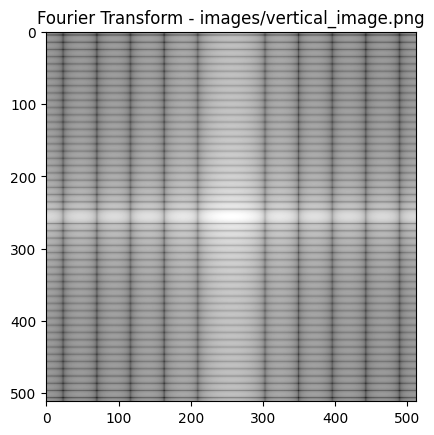

In [162]:
calculate_fourier_transform(image_vertical_path)

Opis i wnioski:
Transformata Fouriera pozwala przenieść obraz z dziedziny przestrzeni pikseli do dziedziny częstotliwości (dziedzina wartości dla której obliczana jest Transformata) i filtrować w tej dziedzinie - posiada swój odpowiednik w dziedzinie obrazu co wynika wprost z definicji. Nie umożliwia nam bezpośredniego połączenia cech obrazu z transformatą, pozwala jedynie wyznaczyć pewne trendy w zależności od tego jakie częstotliwości występują w obrazie, co można interpretować jako zmiany cech obrazu - np poziomów, szarości, jasności.
Niskie wartości częstotliwości odnoszą się do wolnych, małych, stopniowych zmian w poziomach szarości w danym miejscu obrazu, co może odnosić się do obszarów o gładkich przejściach pomiędzy obiektami. Natomiast wysokie częstotliwości odnoszą się do nagłych zmian jasności, co może odpowiadać np. krawędziom czy szumom.
Innymi słowy poprzez analizę widma uzyskanego z transformacji Fouriera, możemy określić, które częstotliwości dominują w różnych obszarach obrazu i jakim cechom (szarości) odpowiadają na analizowanym obrazie.
Dla białych prostokątów, poziomego i pionowego, widmo transformacji w rozumieniu Fouriera przebiegła poprawnie.

2. Dla dwóch wybranych obrazów zastosuj filtry dolno- i górnoprzepustowe w dziedzinie częstotliwości:
a) idealny
b) Gaussa
c) Butterwortha (n=2 i 3)
Dla wszystkich filtrów wybierz ten sam promień.

In [163]:
image_arduino_circuit_path = "images/arduino-circuit.jpg"

In [164]:
def filter_image(image_path, radius, flag, filter_type, n=None):
    image = cv2.imread(image_path, 0)

    f_transform = np.fft.fft2(image)
    f_shift = np.fft.fftshift(f_transform)

    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2

    if filter_type == 'ideal':
        if flag == 'low':
            mask = np.zeros((rows, cols), np.uint8)
            mask[crow - radius:crow + radius, ccol - radius:ccol + radius] = 1
        elif flag == 'high':
            mask = np.ones((rows, cols), np.uint8)
            mask[crow - radius:crow + radius, ccol - radius:ccol + radius] = 0
        else:
            raise ValueError("Flag should be either 'low' or 'high.'")
    elif filter_type == 'gaussian':
        x = np.linspace(-ccol, ccol, cols)
        y = np.linspace(-crow, crow, rows)
        x, y = np.meshgrid(x, y)
        g_mask = np.exp(-(x ** 2 + y ** 2) / (2 * radius ** 2))

        if flag == 'low':
            mask = g_mask
        elif flag == 'high':
            mask = 1 - g_mask
        else:
            raise ValueError("Flag should be either 'low' or 'high.'")
    elif filter_type == 'butterworth':
        x = np.linspace(-ccol, ccol, cols)
        y = np.linspace(-crow, crow, rows)
        x, y = np.meshgrid(x, y)
        d = np.sqrt(x ** 2 + y ** 2)

        if flag == 'low':
            mask = 1 / (1 + (d / radius) ** (2 * n))
        elif flag == 'high':
            mask = 1 - 1 / (1 + (d / radius) ** (2 * n))
        else:
            raise ValueError("Flag should be either 'low' or 'high.'")
    else:
        raise ValueError("Filter type should be 'ideal', 'gaussian', or 'butterworth'.")

    f_shift_filtered = f_shift * mask
    f_ishift = np.fft.ifftshift(f_shift_filtered)
    image_back = np.fft.ifft2(f_ishift)
    image_back = np.abs(image_back)

    plt.subplot(1, 2, 1), plt.imshow(image, cmap='gray')
    plt.title('Input Image'), plt.xticks([]), plt.yticks([])
    if flag == 'low':
        if filter_type == 'ideal':
            plt.subplot(1, 2, 2), plt.imshow(image_back, cmap='gray')
            plt.title('Ideal Low Pass Filter'), plt.xticks([]), plt.yticks([])
        elif filter_type == 'gaussian':
            plt.subplot(1, 2, 2), plt.imshow(image_back, cmap='gray')
            plt.title('Gaussian Low Pass Filter'), plt.xticks([]), plt.yticks([])
        elif filter_type == 'butterworth':
            plt.subplot(1, 2, 2), plt.imshow(image_back, cmap='gray')
            plt.title(f"Butterworth Low Pass Filter (n={n})"), plt.xticks([]), plt.yticks([])
    else:
        if filter_type == 'ideal':
            plt.subplot(1, 2, 2), plt.imshow(image_back, cmap='gray')
            plt.title('Ideal High Pass Filter'), plt.xticks([]), plt.yticks([])
        elif filter_type == 'gaussian':
            plt.subplot(1, 2, 2), plt.imshow(image_back, cmap='gray')
            plt.title('Gaussian High Pass Filter'), plt.xticks([]), plt.yticks([])
        elif filter_type == 'butterworth':
            plt.subplot(1, 2, 2), plt.imshow(image_back, cmap='gray')
            plt.title(f"Butterworth High Pass Filter (n={n})"), plt.xticks([]), plt.yticks([])
    plt.show()


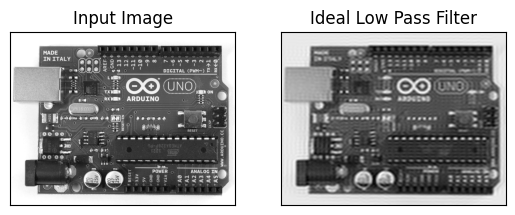

In [165]:
filter_image(image_path=image_arduino_circuit_path, radius=50, filter_type="ideal", flag="low", n=None)

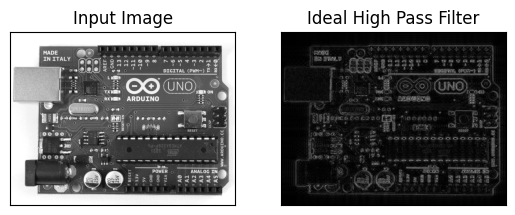

In [166]:
filter_image(image_path=image_arduino_circuit_path, radius=50, filter_type="ideal", flag="high", n=None)

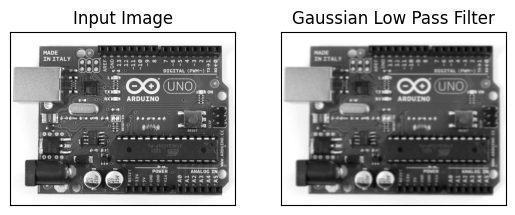

In [167]:
filter_image(image_path=image_arduino_circuit_path, radius=50, filter_type="gaussian", flag="low", n=None)

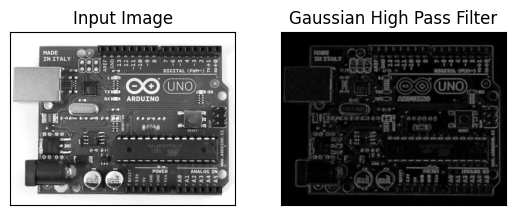

In [168]:
filter_image(image_path=image_arduino_circuit_path, radius=50, filter_type="gaussian", flag="high", n=None)

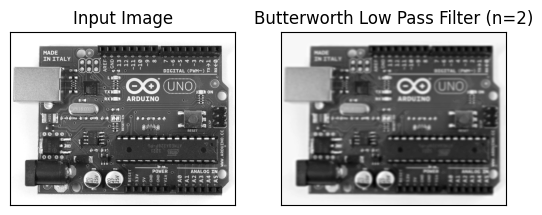

In [169]:
filter_image(image_path=image_arduino_circuit_path, radius=50, filter_type="butterworth", flag="low", n=2)

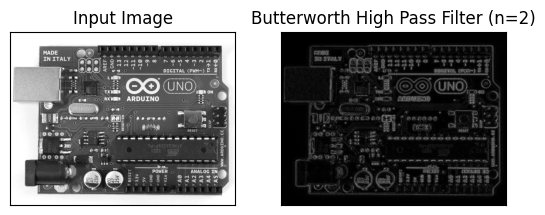

In [170]:
filter_image(image_path=image_arduino_circuit_path, radius=50, filter_type="butterworth", flag="high", n=2)

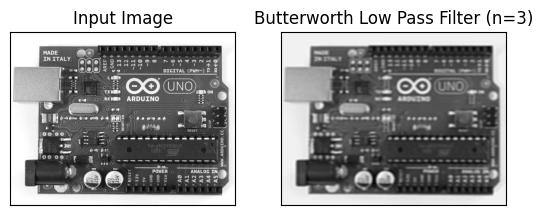

In [171]:
filter_image(image_path=image_arduino_circuit_path, radius=50, filter_type="butterworth", flag="low", n=3)

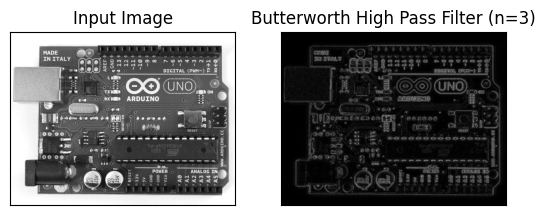

In [172]:
filter_image(image_path=image_arduino_circuit_path, radius=50, filter_type="butterworth", flag="high", n=3)

In [173]:
image_ship_path = "images/ship.jpg"

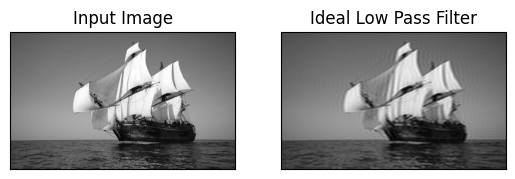

In [174]:
filter_image(image_path=image_ship_path, radius=50, filter_type="ideal", flag="low", n=None)

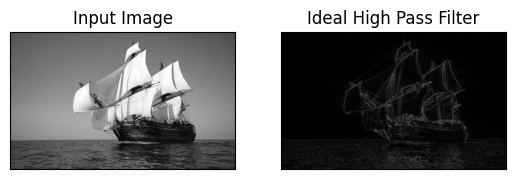

In [175]:
filter_image(image_path=image_ship_path, radius=50, filter_type="ideal", flag="high", n=None)

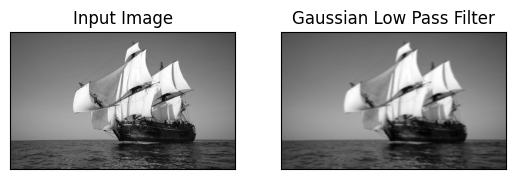

In [176]:
filter_image(image_path=image_ship_path, radius=50, filter_type="gaussian", flag="low", n=None)

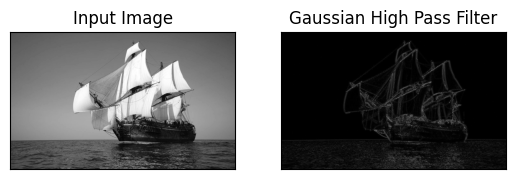

In [177]:
filter_image(image_path=image_ship_path, radius=50, filter_type="gaussian", flag="high", n=None)

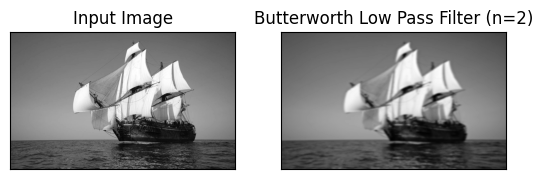

In [178]:
filter_image(image_path=image_ship_path, radius=50, filter_type="butterworth", flag="low", n=2)

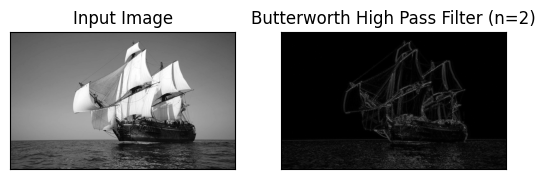

In [179]:
filter_image(image_path=image_ship_path, radius=50, filter_type="butterworth", flag="high", n=2)

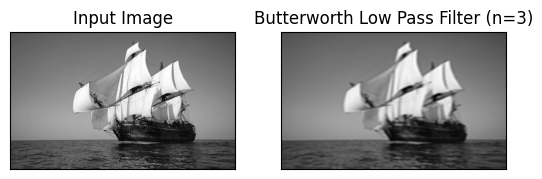

In [180]:
filter_image(image_path=image_ship_path, radius=50, filter_type="butterworth", flag="low", n=3)

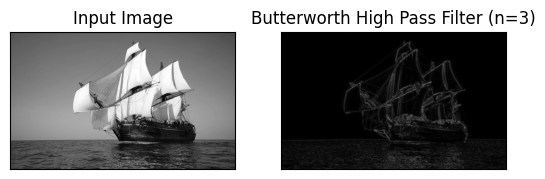

In [181]:
filter_image(image_path=image_ship_path, radius=50, filter_type="butterworth", flag="high", n=3)

Opis i wnioski:
Jak wiadomo filtry obrazu to techniki przetwarzania obrazów, które służą do modyfikacji lub wzmocnienia wybranych cech obrazu poprzez manipulację stanem jego pikselów. W naszym przypadku zostały wykorzystane filtry górno-przepustowe (tłumi niskie wartości częstotliwości, przepuszcza wysokie), których zastosowanie skutkuje mniej ostrymi szczegółami oraz dolno-przepustowe (tłumi wysokie wartości częstotliwości, przepuszcza niskie), których zastosowanie skutkuje wyróżnieniem szczegółów. Oba oczywiście korzystają z Transformaty Fouriera, a dokładnie z jej odwrotności - zmiana z dziedziny częstotliwości na dziedzinę obrazu ponieważ niektóre operacje poprawy obrazy są trudne lub niemożliwe w dziedzinie obrazu, a w dziedzinie częstotliwości są łatwe do wykonania.
- Filtr idealny jest filtrem, który eliminuje wszystkie częstotliwości powyżej lub poniżej określonego punktu odcięcia (będącego odległością od środka transformaty, promieniem). Dla filtra dolnoprzepustowego, filtr idealny przepuszcza wszystkie częstotliwości poniżej punktu odcięcia i eliminuje wszystkie powyżej.
Zaś dla filtra górnoprzepustowego, filtr idealny przepuszcza wszystkie częstotliwości powyżej punktu odcięcia i eliminuje wszystkie poniżej.
- Filtr gaussowski jak sama nazwa wskazuje wykorzystuje krzywą Gaussa, która posiada łagodny przebieg. Używany jest do wygładzenia lub wyostrzenia sygnału, lepiej dopasowuje się do szczegółów obrazu. Mają bardziej stopniową charakterystykę przejścia niż filtry idealne. Filtr Gaussa powoduje, że sygnały o niższych częstotliwościach są mniej tłumione, a te o wyższych częstotliwościach są bardziej tłumione.
- Filtr Butterwortha opisywany przez funkcje typu eliptycznegp, cechuje się płaską charakterystyką częstotliwościową w paśmie przepustowym, co oznacza minimalne tłumienie sygnału w tym paśmie. Filtr ten minimalizuje zniekształcenia sygnału w paśmie przepustowym, w przeciwieństwie do Gaussowskiego który charakteryzuje się stopniowym tłumieniem częstotliwości powyżej punktu odcięcia zgodnie z krzywą, co oznacza, że sygnały o niższych częstotliwościach są mniej tłumione niż te o wyższych częstotliwościach. Wartość n określa rząd filtru i im wyższa wartość tego współczynnika, tym bardziej efektywne jest tłumienie sygnałów poza pasmem przepustowym - zwanym pasmem zaporowym.

Gauss bardziej dokładnie wygładza moje obrazy, niż filtr idealny. Myślę że w przypadku Butterwortha można zauważyć  uzyskanie bardziej stromych różnic w spektrum szarości poza pasmem przepustowym.
